In [1]:
import pandas as pd
#import spam.csv to df
df = pd.read_csv("spam.csv", encoding="ISO-8859-1")
#use only first two columns
df = df[["v1", "v2"]]
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [2]:
#rename v2 and v2
df.rename(columns={'v1': 'Label', 'v2': 'Message'}, inplace=True)
df.head()

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
#Find the row/index has NaN
df["Message"][df["Message"].isna()]

Series([], Name: Message, dtype: object)

In [4]:
df.info
df.shape

(5572, 2)

In [5]:
from collections import Counter              
import nltk 
import itertools
words_all = [nltk.word_tokenize(s) for s in df["Message"]] #tokenize all tweets

words_all = list(itertools.chain.from_iterable(words_all)) #list of all words across all messages

words_all = [s.lower() for s in words_all] # turns letters to lowercases

global_stopwords = nltk.corpus.stopwords.words("english") #remove all stopwords
global_stopwords=global_stopwords+["..."]  
words_all = [s for s in words_all if s not in global_stopwords]

words_all = [s for s in words_all if len(s)>2] #remove all tokens containing no more than 2 characters

stemmer = nltk.stem.SnowballStemmer("english") #apply stemming to all tokens
words_all = [stemmer.stem(s) for s in words_all]

len(words_all)

46102

In [6]:
from afinn import Afinn
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

afinn = Afinn(emoticons=True)        #Initialize an analyzer

df["AFINN"]=[afinn.score(s) for s in df["Message"]]

df["TextBlob"]=[TextBlob(s).sentiment.polarity for s in df["Message"]]
analyzer=SentimentIntensityAnalyzer()

df["VADER"]=[analyzer.polarity_scores(s)['compound'] for s in df["Message"]]

df

,Label,Message,AFINN,TextBlob,VADER
0,ham,"Go until jurong point, crazy.. Available only ...",1.0,0.150000,0.4019
1,ham,Ok lar... Joking wif u oni...,0.0,0.500000,0.4767
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,5.0,0.300000,0.7964
3,ham,U dun say so early hor... U c already then say...,0.0,0.100000,0.0000
4,ham,"Nah I don't think he goes to usf, he lives aro...",0.0,0.000000,-0.1027
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,4.0,0.180556,0.8805
5568,ham,Will Ì_ b going to esplanade fr home?,0.0,0.000000,0.0000
5569,ham,"Pity, * was in mood for that. So...any other s...",-2.0,-0.112500,-0.2960
5570,ham,The guy did some bitching but I acted like i'd...,5.0,0.216667,0.8934


In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

stemmer = nltk.stem.SnowballStemmer("english", ignore_stopwords=True)
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
    
nltk_stopwords = nltk.corpus.stopwords.words("english") 
vectorizer = StemmedCountVectorizer(stop_words=nltk_stopwords)

DTM1 = vectorizer.fit_transform(df["Message"])
DTM1.shape

(5572, 7210)

In [8]:
#total frequency of each term across the corpus
vectorizer = StemmedCountVectorizer(stop_words=nltk_stopwords)
DTM1 = vectorizer.fit_transform(df["Message"])
dfTF = pd.DataFrame({'Term': vectorizer.get_feature_names(),
                   'Frequency': DTM1.sum(axis=0).tolist()[0]
                  })

dfTF.sort_values(by="Frequency",inplace=True,ascending=False)
dfTF.reset_index(inplace=True,drop=True)

dfTF.head(20)

,Term,Frequency
0,call,672
1,go,453
2,get,452
3,ur,385
4,gt,318
5,lt,316
6,come,301
7,ok,292
8,free,284
9,know,274


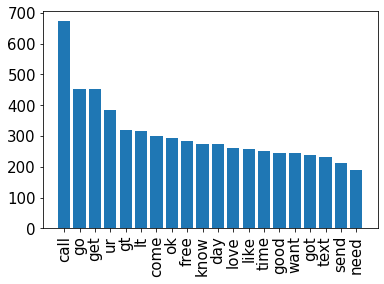

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt

top = 20                                              #how many top terms to show
fig, ax = plt.subplots()
ax.bar(dfTF.Term[0:top],dfTF.Frequency[0:top])        #define x and y axis.
plt.rcParams['figure.figsize'] = (10,2)               #Figure size displayed in notebook
plt.xticks(rotation=90,fontsize= 15)                  #Rotate and size x labels. 
plt.yticks(fontsize= 15)                              #size y labels.  
plt.show()

In [10]:
#split df into training 70% and testing 30%
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size = 0.30,
                                    random_state = 2021
                                    )
df_train.reset_index(drop=True,inplace=True)
df_test.reset_index(drop=True,inplace=True)
#Check your answer:
df_test.head()

,Label,Message,AFINN,TextBlob,VADER
0,ham,Should i buy him a blackberry bold 2 or torch....,2.0,0.234848,0.3818
1,ham,You call him now ok i said call him,0.0,0.500000,0.2960
2,ham,Hi here. have birth at on the to at 8lb 7oz....,0.0,0.900000,0.6124
3,ham,No:-)i got rumour that you going to buy apartm...,3.0,0.500000,0.0000
4,spam,1st wk FREE! Gr8 tones str8 2 u each wk. Txt N...,4.0,0.333333,0.8412


In [11]:
#building actual predictive model
import numpy as np
from sklearn.svm import l1_min_c
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import MaxAbsScaler

vectorizer=StemmedTfidfVectorizer(stop_words=nltk_stopwords,
                                  use_idf=True,
                                  smooth_idf=False,
                                  norm="l1")
train_x = vectorizer.fit_transform(df_train["Message"])
train_y = df_train["Label"]
test_x = vectorizer.transform(df_test["Message"])
test_y = df_test["Label"]

scaler = MaxAbsScaler()
scaler.fit(train_x)
train_x=scaler.transform(train_x)
test_x=scaler.transform(test_x)

Clist = l1_min_c(train_x, train_y, loss='log') * np.logspace(start=0, stop=15, num=20)

sparselr = LogisticRegressionCV(penalty='l1', 
                                solver='liblinear', 
                                Cs=Clist,    
                                cv=5,       
                                scoring='roc_auc', 
                                random_state=2021,   #Random seed set to be 2021.
                                tol=0.001,           #The default value of tol is 0.0001
                                max_iter=100
                               )
sparselr.fit(train_x, train_y)

#Check your solution:
print(train_x.shape)

(3900, 5977)


In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

print(confusion_matrix(test_y,sparselr.predict(test_x)))
print(accuracy_score(test_y,sparselr.predict(test_x)))
print(roc_auc_score(test_y,sparselr.predict_proba(test_x)[:, 1]))

[[1439   14]
 [  24  195]]
0.9772727272727273
0.9842838152523359
